# Import e path

In [8]:
# !pip install einops
# !pip install vit_pytorch

In [9]:
models_save_path        = "./model"
results_save_path_agent = "./result"
dataset_path            = "./dataset"

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:
# Libraries for data handling
import numpy as np
import pandas as pd

# Libraries for image manipulation and machine learning
import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.nn import functional
import torch.optim as optim

# Library to load in tinyimagenet
from tinyimagenet import TinyImageNet
from pathlib import Path

!pip install scikit-learn

# Libraries for model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Libraries for tensor manipulation
from einops import rearrange
from einops.layers.torch import Rearrange

# Libraries for simulation environments (gym)
import gym

# Libraries for data visualization
import matplotlib.pyplot as plt

# Other common libraries
from collections import namedtuple
import math
import time
import os
import random

from dqn_agent import *
from train_test_agent import *
from rl_env import *
from vit import *
from viz import *

<h3> Seed and Device setting

In [12]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Dataset

<h3> Dataset Parameters

In [14]:
batch_size = 128
img_size = 64
# dataset_name = "CIFAR10_BIG_"
# dataset_name = "TinyImageNet"

## Train, validation and test

In [105]:
datasets = ["tinyimagenet", "cifar10"]
dataset_idx = 0
dataset_name = datasets[dataset_idx]
use_subset = False
subset_classes = 20

transform_train = transforms.Compose([
    transforms.RandomCrop(img_size, padding=8),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std),
])

transform_validation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std),
])




# Prepare and load TinyImageNet dataset
if (dataset_idx == 0):
    trainset_pure = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="train",imagenet_idx=False)
    trainset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="train",imagenet_idx=False, transform=transform_train)
    validationset = TinyImageNet(Path("~/.torchvision/tinyimagenet/"),split="val",imagenet_idx=False, transform=transform_validation)

if (dataset_idx == 1):
    # Prepare/download CIFAR10 dataset
    trainset_pure = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=transform_train)
    validationset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_validation)

print("Dataset downloaded!")
# Only select 20 classes from tinyimagenet.
if use_subset:
    print("Using subset of {} classes".format(subset_classes))
     # Select 20 random classes
    selected_classes = list(range(subset_classes))
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}


    # Filter the dataset to include only the selected classes
    train_subset_indices = [i for i, (_, label) in enumerate(validationset) if label in selected_classes]
    val_subset = data.Subset(validationset, train_subset_indices)
    val_subset_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]
    train_subset = data.Subset(trainset, val_subset_indices)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    print("trainloader created successfully.")
    dataset_size = len(val_subset)
    validation_size = int(0.95 * dataset_size)
    test_size = dataset_size - validation_size

    val_subset, test_subset = data.random_split(val_subset, [validation_size, test_size])

    validation_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    classes = class_to_idx
    print(len(np.unique(val_subset.indices)))
    print(len(np.unique(train_subset.indices)))

else:
    dataset_size = len(validationset)
    validation_size = int(0.95 * dataset_size)
    test_size = dataset_size - validation_size
    validationset, testset = data.random_split(validationset, [validation_size, test_size])
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    validation_loader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    classes = trainset.classes

# classes = trainset.classes

print(classes)

Dataset downloaded!
['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02

# Agent

### Functions for training and validation

### Initialization

In [16]:
buffer_batch_size = 8
buffer_size = 64

gamma = 0.95

eps_start = 1
eps_end = 0.01
eps = eps_start
eps_decay = 20000

lr = 0.01

tau = 0.1
update_every = 2

get_reward_every = 10

pretrained = False # Pretrained with CIFAR10 weights, that is.

max_reward = 10
alpha = 0.2 # Where alpha defines weight of loss reward, and 1-alpha defines weight of patch (time) reward
# loss_weight = max_reward*(alpha)  # TODO THIS ONE TOO
# time_weight = max_reward*(1-alpha) # TODO PLAY WITH THESE VALUES A LOT
loss_weight = alpha
time_weight = 1-alpha

# Input image to DQN agent's  Q-network
# for CIFAR, lowres=16, fullres=32
# For TinyImageNet, halfres = 32, fullres = 64
dqn_img_w = 32
dqn_input_channels = 3
dqn_input_size = dqn_img_w*dqn_img_w*dqn_input_channels # input to DQN (mlp type)

In [17]:
# This is the number of patches along the width/height of the square image.
# TODO refactor...img_size is defined WAY up in the notebook, right before dataset loader initialization
patch_width = 8
# patch_size = int(img_size/patch_width)
patch_size = patch_width # This is what you get when you work with someone else's code and don't want to rewrite everything.


total_patches = int((img_size/patch_width)**2)
print(total_patches)
n_patch_selected = int(total_patches*(40/64)) # From the paper


att_dim = 128

epochs = 20
learning_rate = 0.001

ViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

# Sposta il modello sulla GPU (se disponibile)
ViTnet.to(device)

# definiamo l'ottimizzatore
optimizer = optim.Adam(ViTnet.parameters(), lr=learning_rate)

64


In [18]:


#env = ViTEnv(ViTnet, total_patches, optimizer, loss_weight, time_weight, device, n_patch_selected)
env = ViTEnv(ViTnet, total_patches, optimizer, loss_weight, time_weight, device, n_patch_selected, total_epochs=epochs)

In [19]:
model = TrainingTestingAgent(epochs = epochs,
                             model = ViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = env,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             device = device,
                             dqn_input_size=dqn_input_size,
                             pretrained=pretrained)

ConvNet created! Value of pretrained: False
ConvNet created! Value of pretrained: False


In [20]:
model = TrainingTestingAgent(epochs = epochs,
                             model = ViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = env,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             device = device,
                             dqn_input_size=dqn_input_size,
                             pretrained=pretrained)

ConvNet created! Value of pretrained: False
ConvNet created! Value of pretrained: False


### Train SimpleViT (no patch selection)

In [21]:
# Training loop for SimpleViT
def train_simple_vit(model, train_loader, criterion, optimizer, device, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


trainSimple = False

if trainSimple:

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the SimpleViT model, criterion, and optimizer
    model = SimpleViT(
        image_size = img_size,
        patch_size = patch_size,
        num_classes = len(classes),
        dim = att_dim,
        depth = 6,
        heads = 16,
        mlp_dim = 512).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_simple_vit(model, train_loader, criterion, optimizer, device, num_epochs=10)

In [110]:
import torch 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def get_patch_coordinates(patch_index, patch_size, num_patches_per_row):
    row = patch_index // num_patches_per_row
    col = patch_index % num_patches_per_row
    return row * patch_size , col * patch_size

def visualize_selected_patches(image, input_img, model_agent, device):
    # model_agent.eval()
    with torch.no_grad():
        patches = model_agent.select_action(input_img.to(device))
        patches = [1 if patch > patches.mean() else 0 for patch in patches]
    
    patch_size = model_agent.patch_size
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
   
    # ax.imshow(image.cpu().numpy())
    num_patches_per_row = int(image.size(1) // patch_size)
    for i, patch in enumerate(patches):
        if patch == 0:
            y, x = get_patch_coordinates(i, patch_size, num_patches_per_row)
            rect = plt.Rectangle((x-1, y-1), patch_size, patch_size, edgecolor='none', facecolor='gray', alpha=0.9)
            # rect = plt.Rectangle((x, y), patch_size, patch_size, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    
    plt.show()


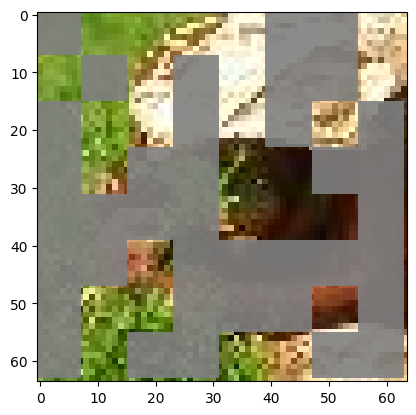

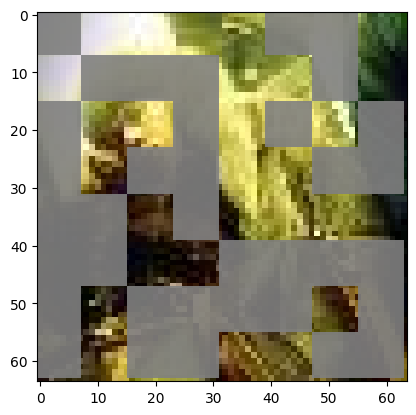

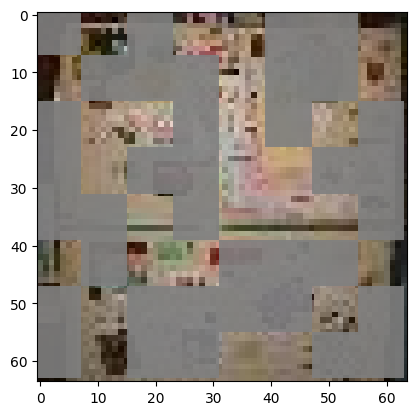

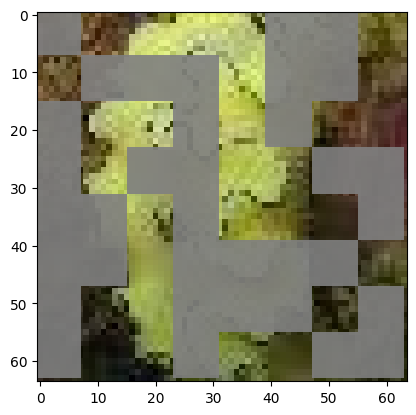

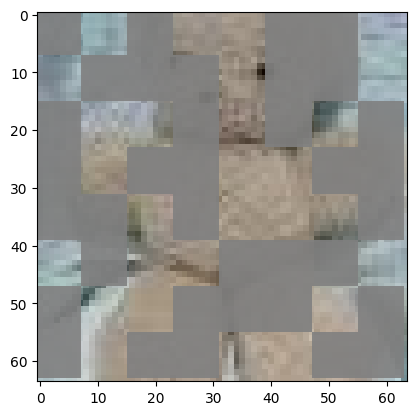

In [111]:
## Visualize the patch selection and attention scores for the untrained models.
## Use functions defined in viz.py
# Select a random set of 5 images from the dataset
num_images = 5
random_indices = np.random.choice(len(trainset_pure), num_images, replace=False)
random_images = [trainset_pure[i][0] for i in random_indices]



half_norm_transform = transforms.Compose(
    [transforms.Resize((img_size // 2, img_size // 2)), 
    transforms.Normalize(mean=TinyImageNet.mean, std=TinyImageNet.std)]
    )

# Visualize the patch selection and attention scores
for img in random_images:
    input_img = half_norm_transform(img)
    visualize_selected_patches(img, input_img, model.agent, device)
    # visualize_attention_scores(img, model.ViTnet, device)


### Train AgentViT

In [ ]:
initial = time.time()
step_reward, selected_patch = model.train_test(models_save_path, dataset_name)
print(f'Total Time: {time.time()-initial}')

Epoch: 1/20
  Patch list: [0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
  Selected Patches: 29
  loss_reward: 1.0
  patches_reward: -0.4583333333333333
  Epsilon: 0.9995546002224661,   Reward: -0.13124999999999998
  Patch list: [0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]
  Selected Patches: 29
  loss_reward: 1.0290664582785751
  patches_reward: -0.4583333333333333
  Epsilon: 0.9990599465960667,   Reward: -0.12427405001314196
  Patch list: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]
  Selected Patches: 35
  loss_reward: 1.0126830615686864
  patches_r

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch time: 88.30744934082031
########################################
########################################
Episode End
########################################
########################################
Epoch: 2/20
  Patch list: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
  Selected Patches: 32
  loss_reward: 1.1200754826770007
  patches_reward: -0.3333333333333333
  Epsilon: 0.9616096727775215,   Reward: 0.04028780181622693
  Patch list: [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]
  Selected Patches: 31
  loss_reward: 1.1109225930620854
  patches_reward: -0.375
  Epsilon: 0.961133986872519,   Reward: 0.0035583260573839315
  Patch list: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch time: 88.07994604110718
########################################
########################################
Episode End
########################################
########################################
Epoch: 3/20
  Patch list: [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]
  Selected Patches: 34
  loss_reward: 1.2282337290909409
  patches_reward: -0.25
  Epsilon: 0.9251197610724647,   Reward: 0.18553479330910114
  Patch list: [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
  Selected Patches: 36
  loss_reward: 1.1970704605674851
  patches_reward: -0.16666666666666666
  Epsilon: 0.924662315562836,   Reward: 0.24472921404826198
  Patch list: [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0

<h3> Train and Validation Informations

In [ ]:
results_train = model.train_info()
train_loss = results_train['train_loss']
train_time = results_train['train_time']

In [ ]:
results_validation = model.validation_info()
validation_loss = results_validation['validation_loss']
validation_acc = results_validation['validation_acc']

<h3> Saving Results in CSV format


In [ ]:
save_name="halfres_pretrained-frozen-cnn_default-configs_8patch_rebalanceR"

df = pd.DataFrame(results_train)

df.to_csv(f'{results_save_path_agent}{dataset_name}_train_lowres_dr_e100_{save_name}.csv', index=False)

In [ ]:
df = pd.DataFrame(results_validation)

df.to_csv(f'{results_save_path_agent}{dataset_name}_validation_lowres_dr_e100_{save_name}.csv', index=False)

### Plot of Results

<h3> Train Loss during iterations

In [ ]:
model_name = "half-Res Pretrained frozen CNN (Default Configs), 8x8 patches, ReBalance Reward"

plt.plot(range(len(train_loss)), train_loss, label='Train Loss')

plt.legend()
plt.title('Loss over time: {}'.format(model_name))
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

<h3> Validation Loss during epochs

In [ ]:
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')

plt.legend()
plt.title('Loss over time: {}'.format(model_name))
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

<h3> Validation Accuracy during epochs

In [ ]:
x = range(len(validation_acc))
y = validation_acc

plt.plot(x, y, label='Validation Accuracy')

plt.legend()
plt.title('Accuracy over time: {}'.format(model_name))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
validation_acc

## Evaluation for different Heuristics

In [ ]:
def evaluate_agent(agent, data_load, device, mode = False):

    agent.eval()

    elements = 0
    csamp = 0
    tloss = 0

    with torch.no_grad():
        for data, target in data_load:

            elements += len(data)
            data = data.to(device)
            target = target.to(device)

            state = env.get_state(data)

            if mode == "agent":
              action = model.agent.select_action(state)
            elif mode == "random":
              action = model.env.action_space.sample()
            else:
              action = torch.tensor([1 for i in range(len(model.env.action_space.sample()))], dtype = torch.float)

            ViTnet.set_patches(action)

            output = functional.log_softmax(agent(data), dim=1)
            loss = functional.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            tloss += loss.item()
            csamp += pred.eq(target).sum()

    loss_val = tloss / elements
    acc_val = (100.0 * csamp / elements).cpu()

    print('\nAverage validation loss: ' + '{:.4f}'.format(loss_val) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(elements) + ' (' +
          '{:4.2f}'.format(acc_val) + '%)\n')

    return loss_val, acc_val


### Train

<h3> All Patches

In [ ]:
evaluate_agent(ViTnet, train_loader, device)

<h3> Patches Selected By agent

In [ ]:
# time-dependent reward component
evaluate_agent(ViTnet, train_loader, device, mode = "agent")

<h3> Random Patches

In [ ]:
evaluate_agent(ViTnet, train_loader, device, mode = "random")

### Validation

<h3> All Patches

In [ ]:
evaluate_agent(ViTnet, test_loader, device)

<h3> Patches Selected By agent

In [ ]:
evaluate_agent(ViTnet, test_loader, device, mode = "agent")

<h3> Random Patches

In [ ]:
evaluate_agent(ViTnet, test_loader, device, mode = "random")